## Building a Simple Decision Tree

In this tutorial we'll build a machine learning model that classifies molecules as soluble or insoluble.  After building the model, we'll visualize the results.  

### Software Installation
One of the Python libraries [dtreeviz](https://github.com/parrt/dtreeviz) that we are going to install requires the installation of a program called [graphviz](https://graphviz.org/).  We can use [apt-get](https://help.ubuntu.com/community/AptGet/Howto) to install graphviz. 

In [11]:
!apt-get install graphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Install the necessary Python libraries

In [12]:
!pip install dtreeviz rdkit-pypi PyTDC

  Obtaining dependency information for dtreeviz from https://files.pythonhosted.org/packages/b3/e8/44eb59345d8ba9d2f6610df6441d63082f46021c1685de24716c22f55383/dtreeviz-2.2.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 113.2 kB/s eta 0:00:00m eta 0:00:010:00:08
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 697.6 kB/s eta 0:00:001m423.2 kB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 402.0 kB/s eta 0:00:00 kB/s eta 0:00:01
  Obtaining dependency information for huggingface_hub from https://files.pythonhosted.org/packages/05/09/1945ca6ba3ad8ad6e2872ba682ce8d68c5e63c8e55458ed8ab4885709f1d/huggingface_hub-0.19.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 401.1 kB/s eta 0:00:001m307.2 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 717.7 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Created wheel for PyTDC: filena

### Setup
Import the necessary Python libraries

In [53]:
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision trees
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
# from dtreeviz.trees import * #plotting decision trees
# from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, ConfusionMatrixDisplay # model stats
# import sklearn.metrics.RocCurveDisplay.from_estimator
from tdc.single_pred import ADME
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
import dtreeviz

We want to have progress bars for operations we perfrom on the Pandas dataframe.  In order to do this we neeed to use the function [tqdm.pandas](https://datascientyst.com/progress-bars-pandas-python-tqdm/).

In [14]:
tqdm.pandas()

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

In [15]:
def calc_descriptors(mol):
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

The molecules in this dataset have a number of salts and other functionality that can create issues with descriptor calcuations.  In order to avoid some of these problems we can use the function below to standardize the molecules. 

In [16]:
def standardize(smiles):
    # Code borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

### Reading the Input Data
Read data from ["ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure"](https://pubs.acs.org/doi/10.1021/ci034243x) as supplied by [Therapeutic Data Commons](https://tdcommons.ai/)

In [17]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 853k/853k [00:03<00:00, 271kiB/s]
Loading...
Done!


Let's take a look at the input data, which has three columns
- Drug_ID - the molecule name
- Drug - the SMILES
- Y - the log of the aqueous solubility in uM

In [18]:
sol_df

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


I don't like the names of the columns, let's rename them. 

In [19]:
sol_df.columns = ["Name","SMILES","LogS"]
sol_df

,Name,SMILES,LogS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


Now let's reorder the columns.

In [20]:
sol_df = sol_df[['SMILES','Name','LogS']]
sol_df

,SMILES,Name,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065
...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000


Before we calculate descriptors, we're going to standardize the molecules. This process removes counterions, neutralizes molecules, and generates a standard tautomer.  This process also generates **a lot** of logging output.  We don't want to look at that output, so we're going to use the function [BlockLogs](https://www.rdkit.org/docs/source/rdkit.rdBase.html) to temporarily turn off logging.  Once we're finished we delete the variable **block** and logging is back on.

In [21]:
block = BlockLogs()
sol_df['mol'] = sol_df.SMILES.progress_apply(standardize)
del block

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9982/9982 [01:47<00:00, 92.48it/s]


Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM

In [22]:
sol_df['IsSol'] = sol_df.LogS > math.log10(200 * 1e-6)

Plot solubility as a sanity check

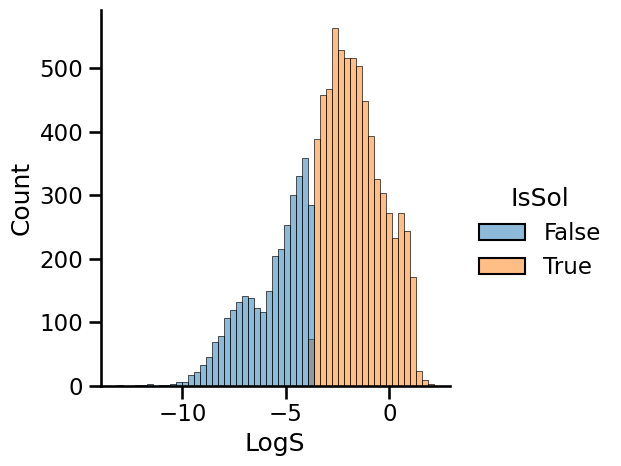

In [23]:
sns.set_context('talk') # Set the fonts the way I like them
sns.displot(x='LogS',hue="IsSol",data=sol_df)

Add the descriptors to the dataframe.  Note that all the descriptors are going into one column called "desc".

In [24]:
sol_df['desc'] = sol_df.mol.progress_apply(calc_descriptors)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9982/9982 [00:01<00:00, 5705.70it/s]


The function call in the cell above put all the descriptors into a single column called **desc**.  We would like split the descriptors so that each is in its own column.

In [25]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.desc.to_list()

We no longer need the "desc" column, let's get rid of it. 

In [26]:
sol_df.drop("desc",axis=1,inplace=True)

Let's check the dataframe to make sure it's ok. 

In [27]:
sol_df

,SMILES,Name,LogS,mol,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x7fc16ddc0660>,True,312.606,6.95410,0,0,0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x7fc16ddc0350>,True,169.183,2.40550,2,1,1
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x7fc16ddc0ac0>,True,140.569,2.15250,1,0,1
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x7fc16ddc0ba0>,False,346.426,5.39400,3,2,2
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x7fc16ddc0430>,False,422.525,2.48540,2,0,6
...,...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x7fc16dc67820>,True,264.369,2.61700,1,1,4
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x7fc16dc67890>,True,444.440,-1.46800,1,4,9
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x7fc16dc67900>,True,150.221,2.82402,1,1,1
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x7fc16dc67970>,False,454.611,5.09308,2,0,6


In order to build a machine learning model, we will split the data into training and test sets. By default, the function train_test_split from scikit_learn puts 80% of the data into the training set and 20% into the test set.

In [28]:
train, test = train_test_split(sol_df)

Our data is currently in a Pandas dataframe.  I find it easier to build models with X and y variables. We'll split the training and test sets into X and y variables. 

In [29]:
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

Create and train a classifier

In [30]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

Predict on the test set

In [31]:
pred = cls.predict(test_X)
auc, mcc, kappa = roc_auc_score(test_y, pred),matthews_corrcoef(test_y,pred),cohen_kappa_score(test_y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.80
Matthews Correlation Coefficient = 0.62
Cohen's Kappa = 0.62


Plot a confusion matrix to show the classifier performance

In [52]:
# plot_confusion_matrix(cls,test_X,test_y)

Plot an ROC cure to show the classifier performance

In [36]:
# plot_roc_curve(cls,test_X,test_y)

Use the default view from SciKit Learn to plot the decision tree

[Text(0.5, 0.8333333333333334, 'LogP <= 3.117\ngini = 0.44\nsamples = 7486\nvalue = [2448, 5038]'),
 Text(0.25, 0.5, 'LogP <= 2.603\ngini = 0.218\nsamples = 5127\nvalue = [637, 4490]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.164\nsamples = 4483\nvalue = [403, 4080]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.463\nsamples = 644\nvalue = [234, 410]'),
 Text(0.75, 0.5, 'HBA <= 13.5\ngini = 0.357\nsamples = 2359\nvalue = [1811, 548]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.339\nsamples = 2307\nvalue = [1809, 498]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.074\nsamples = 52\nvalue = [2, 50]')]

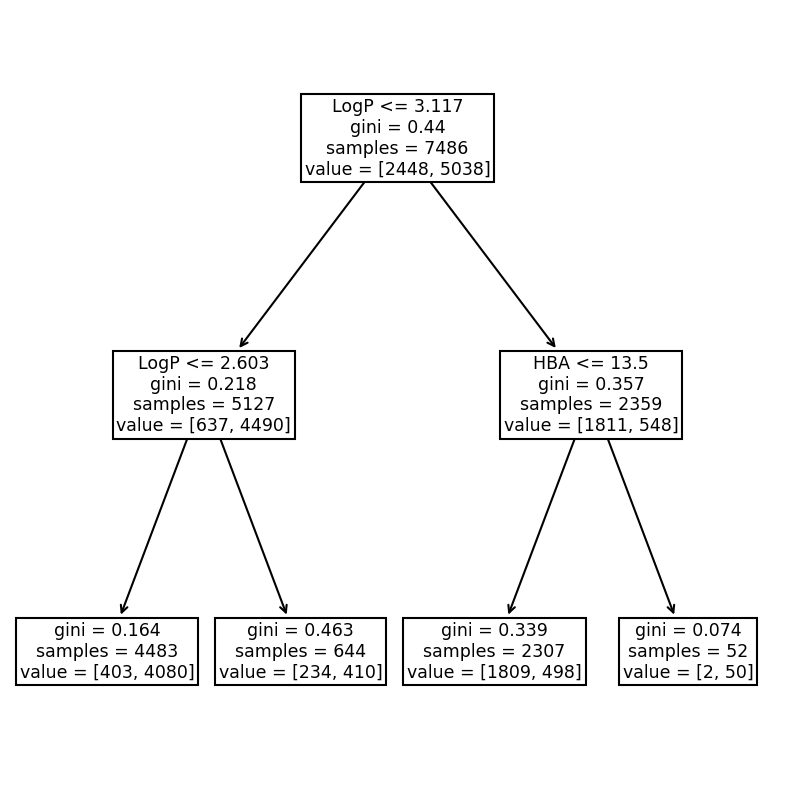

In [37]:
plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)

Use dtreeviz to plot the decision tree

In [56]:
viz = dtreeviz(cls, train_X, train_y, feature_names = desc_cols, 
               target_name = "Solubility",class_names=["False","True"],scale=2)
viz

TypeError: 'module' object is not callable

As a final check we're going to see if we can fit a model to incorrect data.  If we shuffle the y values, we shouldn't be able to get a good model. 

Shuffle the y-variable as a sanity check

In [39]:
sol_df['fake'] = sol_df.IsSol.sample(frac=1)

Split the dataframe into training a test sets. 

In [40]:
fake_train, fake_test = train_test_split(sol_df)

Split the training and test sets into X and y variables

In [41]:
fake_train_X = fake_train[desc_cols]
fake_train_y = fake_train.fake
fake_test_X = fake_test[desc_cols]
fake_test_y = fake_test.fake

Build a classifer

In [42]:
fake_cls = DecisionTreeClassifier(max_depth=2)
fake_cls.fit(fake_train_X,fake_train_y)

DecisionTreeClassifier(max_depth=2)

Generate the predictions

In [43]:
fake_pred = fake_cls.predict(fake_test_X)

Calculate the AUC score

In [44]:
roc_auc_score(fake_test_y,pred)

0.49474444392675765